# Model Interpretation for Pretrained ResNet Model

This notebook demonstrates how to apply model interpretability algorithms on pretrained ResNet model using a handpicked image and visualizes the attributions for each pixel by overlaying them on the image.

The interpretation algorithms that we use in this notebook are `Integrated Gradients` (w/ and w/o noise tunnel),  `GradientShap`, and `Occlusion`. A noise tunnel allows to smoothen the attributions after adding gaussian noise to each input sample.
  
  **Note:** Before running this tutorial, please install the torchvision, PIL, and matplotlib packages.

In [1]:
! pip install captum

     |████████████████████████████████| 4.4MB 10.9MB/s 


In [2]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

## 1- Loading the model and the dataset


Loads pretrained Resnet model and sets it to eval mode

In [3]:
model = models.resnet18(pretrained=True).cuda()
model = model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Downloads the list of classes/labels for ImageNet dataset and reads them into the memory

In [4]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2021-03-08 15:56:41--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.144.189
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.144.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/root/.torch/models/imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.08s   

2021-03-08 15:56:41 (417 KB/s) - ‘/root/.torch/models/imagenet_class_index.json’ saved [35363/35363]



In [5]:
labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

Defines transformers and normalizing functions for the image.
It also loads an image from the folder that will be used for interpretation purposes.

In [6]:
!wget https://raw.githubusercontent.com/pytorch/captum/master/tutorials/img/resnet/swan-3299528_1280.jpg

--2021-03-08 15:56:49--  https://raw.githubusercontent.com/pytorch/captum/master/tutorials/img/resnet/swan-3299528_1280.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 213579 (209K) [image/jpeg]
Saving to: ‘swan-3299528_1280.jpg’

swan-3299528_1280.j 100%[===================>] 208.57K  --.-KB/s    in 0.01s   

2021-03-08 15:56:49 (16.9 MB/s) - ‘swan-3299528_1280.jpg’ saved [213579/213579]



In [10]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('swan-3299528_1280.jpg')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

img.show()

Predict the class of the input image

In [11]:
output = model(input.cuda())
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


Predicted: goose ( 0.45693239569664 )


## 2- Gradient-based attribution

Let's compute attributions using Integrated Gradients and visualize them on the image. Integrated gradients computes the integral of the gradients of the output of the model for the predicted class `pred_label_idx` with respect to the input image pixels along the path from the black image to our input image.

In [12]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input.cuda(), target=pred_label_idx, n_steps=200)





Predicted: goose ( 0.45693239569664 )


Let's visualize the image and corresponding attributions by overlaying the latter on the image.

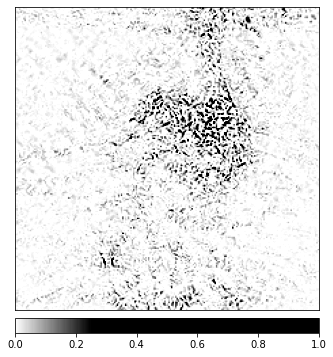

In [13]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

In [14]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input.cuda(),
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)


Let us visualize the attribution, focusing on the areas with positive attribution (those that are critical for the classifier's decision):

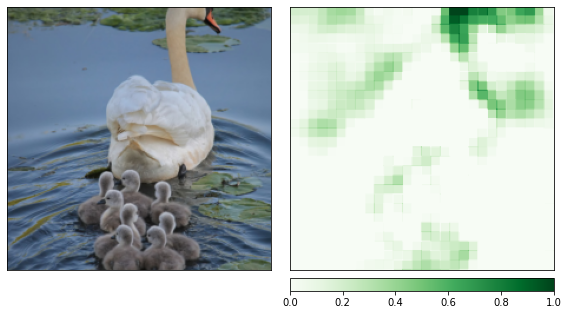

In [15]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )
